# Real Data KPP

This notebook presents how to compute the fits for all real KPP data and produces the figures and table

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fitle import (
    Param, INPUT, fit, Cost,
    gaussian, exponential, crystalball, convolve, identity
)
import mplhep
import uproot
import vector
mplhep.style.use(mplhep.style.LHCb2)

## Setup

Import the required libraries with explicit imports from `fitle` for the modern API.

In [2]:
Dp_M = np.load("../data/observed/kpp.npy")
Dp_M = Dp_M[Dp_M < 1970]

## Data Loading

Load the $K\pi\pi$ mass spectrum and apply the upper mass cut at 1970 MeV.

In [ ]:
# This function makes building models with interpretable N's easier
def model_sum(models, N=None, weights=None):
    if N is None:
        N = +Param
    elif np.isscalar(N):
        N = (+Param)(N)

    if weights is None:
        weights = [Param.unit('w') for _ in range(len(models) - 1)]

    weighted = [
        identity(weights[i] * models[i]) if i < len(models) - 1
        else identity(models[i] * (1 - sum(weights)))
        for i in range(len(models))
    ]

    return identity(N) * sum(weighted)

In [4]:
Dp_x, Dp_c = np.load("../data/mc/histograms/Dp.npy")
Ds_x, Ds_c = np.load("../data/mc/histograms/Ds.npy")

Dp_mother_mass = 1869.65
Ds_mother_mass = 1968.33

## Monte Carlo Templates

Load the MC histogram templates for convolution fits.

In [ ]:
# Bin width for KPP data: 200 bins over [1790, 1970]
bin_width = (1970 - 1790) / 200  # = 0.9

conv_kkp_mass = Param('mass')(1860)
sigma1 = (+Param)(5)
sigma2 = (+Param)(10)

conv_kkp_signal = model_sum([
    convolve(Dp_x, Dp_c, Dp_mother_mass, conv_kkp_mass, sigma1, bin_width=bin_width), 
    convolve(Dp_x, Dp_c, Dp_mother_mass, conv_kkp_mass, sigma2, bin_width=bin_width)
], 1e6)
conv_kkp_tail = (+Param('Nb'))(40000) * exponential(tau=(+Param)(100), start=1790, end=1970)
conv_kkp = conv_kkp_signal + conv_kkp_tail

## Convolution Fits

### Using KKP MC Template (conv_kkp)

First we try using the $KK\pi$ Monte Carlo template to fit the $K\pi\pi$ data. This tests whether the radiative tail shape is similar between channels.

In [ ]:
fit_conv_kkp = fit(conv_kkp | Cost.chi2(Dp_M, 200))
fit_conv_kkp

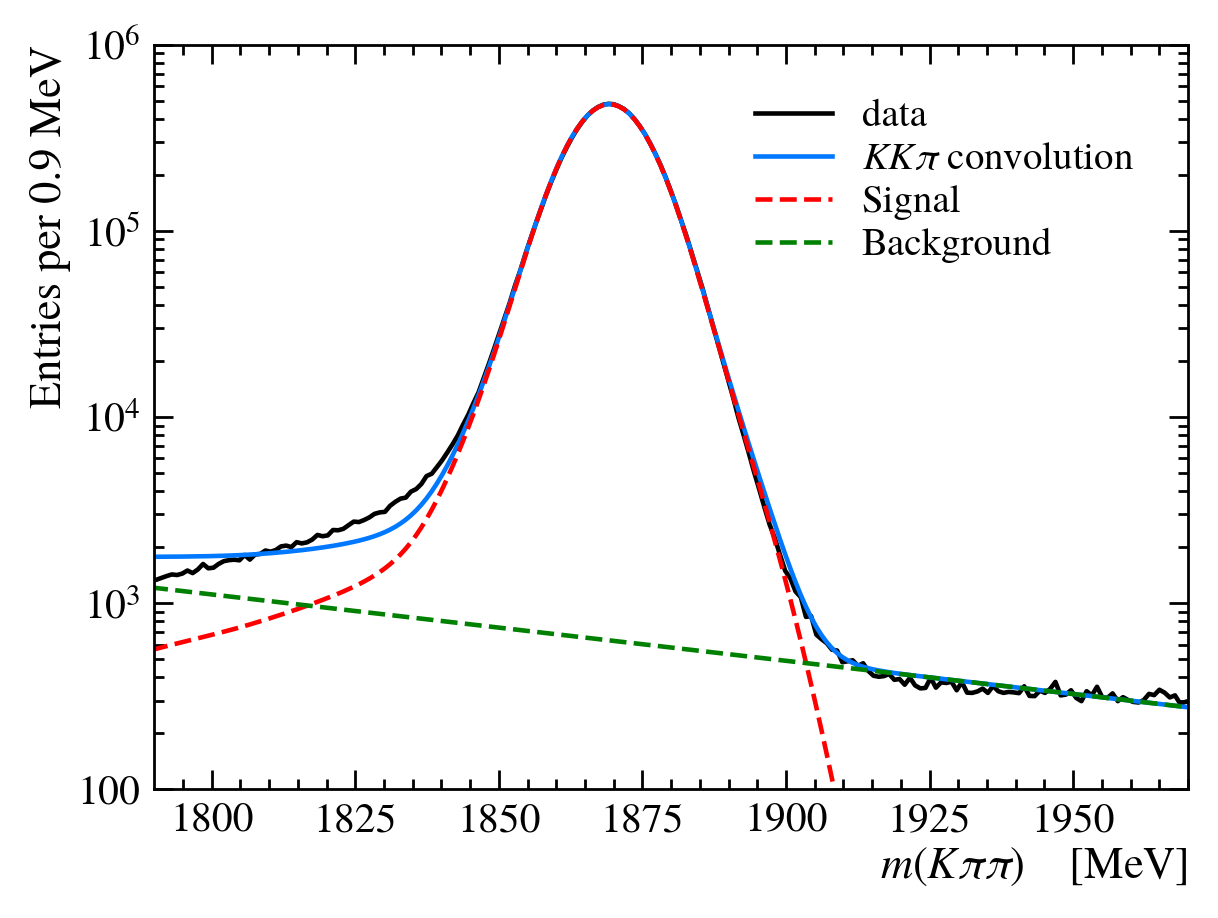

In [40]:
counts, centers = np.histogram(Dp_M, 200)
x = (centers[1:] + centers[:-1])/2
plt.plot(x, counts, color='black', label='data')
plt.plot(x,fit_conv_kkp.predict(x), label='$KK\pi$ convolution')
plt.plot(x,conv_kkp_signal(x) * fit_conv_kkp.bin_widths, linestyle='--',color='red', label='Signal')
plt.plot(x,conv_kkp_tail(x) * fit_conv_kkp.bin_widths, linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [41]:
kpp_x, kpp_c = np.load("../data/mc/histograms/kpp.npy")
Dp_mother_mass = 1869.65

### Using KPP MC Template

Load the channel-specific $K\pi\pi$ Monte Carlo template for more accurate modeling.

In [ ]:
conv1_mass = Param('mass')(1860)
sigma1 = (+Param)(5)
sigma2 = (+Param)(10)

conv1_signal = model_sum([
    convolve(kpp_x, kpp_c, Dp_mother_mass, conv1_mass, sigma1, bin_width=bin_width), 
    convolve(kpp_x, kpp_c, Dp_mother_mass, conv1_mass, sigma2, bin_width=bin_width)
], 1e6)
conv1_tail = (+Param('Nb'))(40000) * exponential(tau=(+Param)(100), start=1790, end=1970)
conv1 = conv1_signal + conv1_tail

### Double Gaussian Convolution (conv1)

Model the $D^+$ signal as a double Gaussian convolution with the KPP template plus an exponential background.

In [ ]:
fit_conv1 = fit(conv1 | Cost.chi2(Dp_M, 200))
fit_conv1

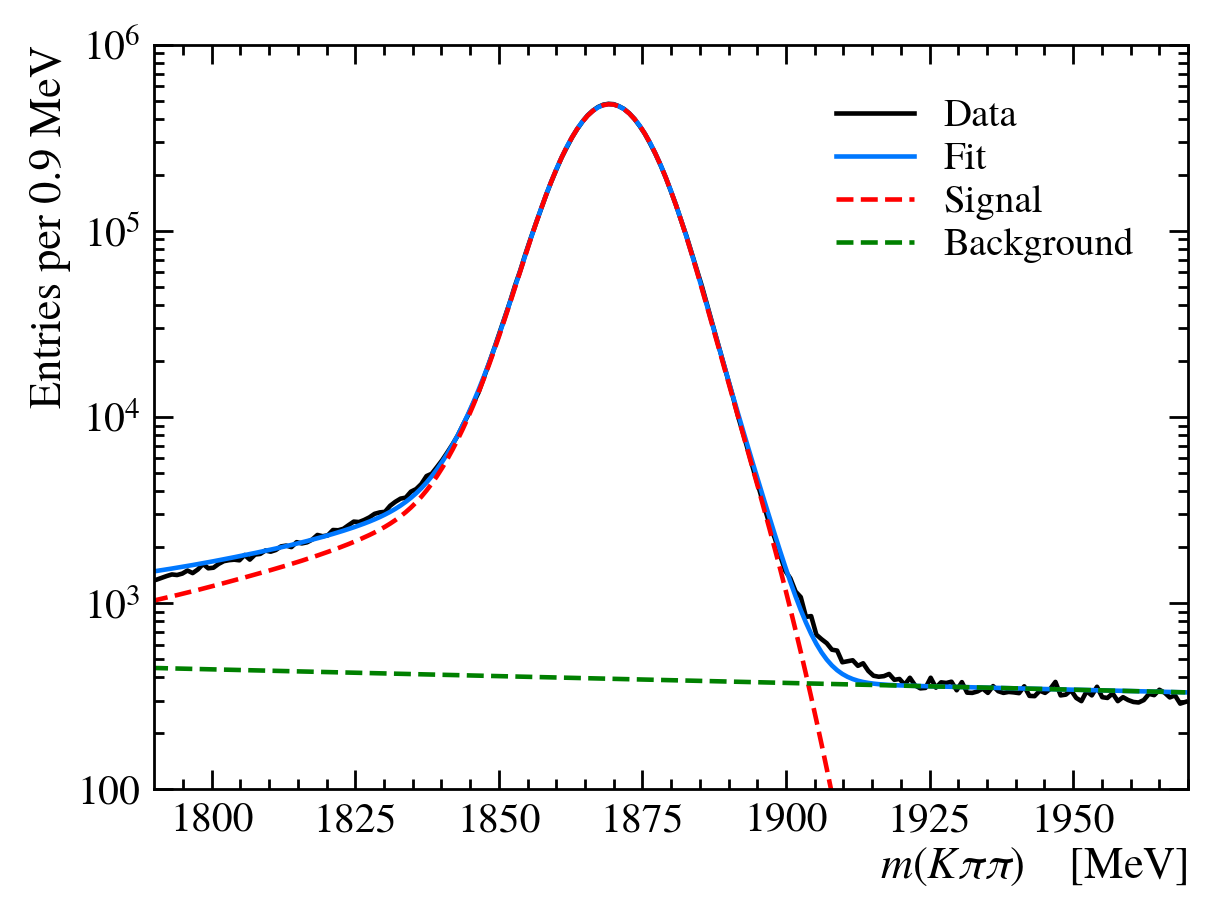

In [44]:
plt.plot(x, counts, color='black', label='Data')
plt.plot(x,fit_conv1.predict(x), label='Fit')
plt.plot(x,conv1_signal(x) * fit_conv1.bin_widths, linestyle='--',color='red', label='Signal')
plt.plot(x, conv1_tail(x) * fit_conv1.bin_widths, linestyle='--',color='green', label='Background')
#plt.plot(tanh1.x,tanh1.gen_y(tanh1.x), color='red', label='$K\pi\pi$ convolution')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [ ]:
conv2_mass = Param('mass')(1860)
sigma1 = (+Param)(5)
sigma2 = (+Param)(6)
sigma3 = (+Param)(10)

conv2_signal = model_sum([
    convolve(kpp_x, kpp_c, Dp_mother_mass, conv1_mass, sigma1, bin_width=bin_width), 
    convolve(kpp_x, kpp_c, Dp_mother_mass, conv1_mass, sigma2, bin_width=bin_width),
    convolve(kpp_x, kpp_c, Dp_mother_mass, conv1_mass, sigma3, bin_width=bin_width)
], 1e6)
conv2_tail = (+Param('Nb'))(40000) * exponential(tau=(+Param)(100), start=1790, end=1970)
conv2 = conv2_signal + conv2_tail

### Triple Gaussian Convolution (conv2)

Extend to a triple Gaussian resolution model for improved fit quality.

In [ ]:
fit_conv2 = fit(conv2 | Cost.chi2(Dp_M, 200))
fit_conv2

In [75]:
fit_conv2.values['x8']

883.7017760136504

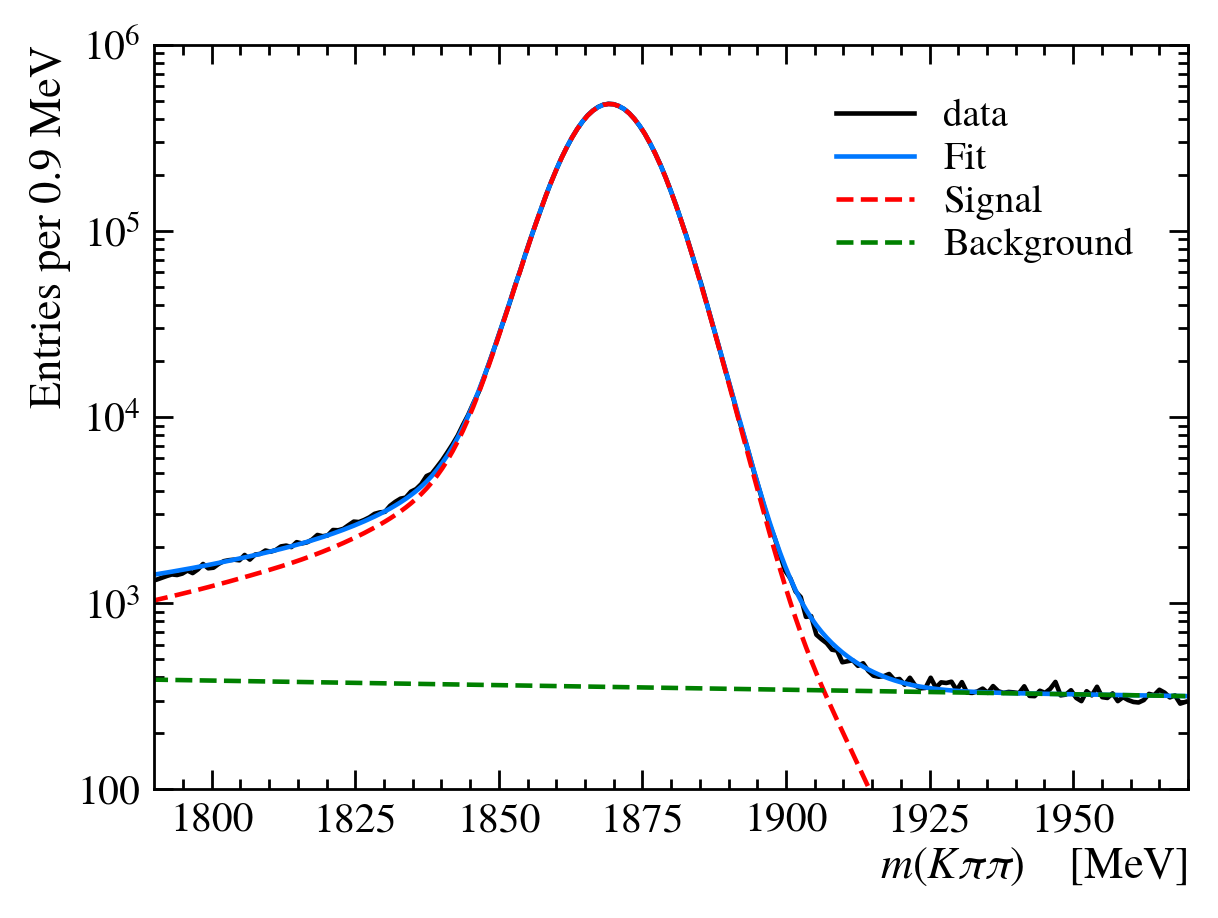

In [47]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,fit_conv2.predict(x), label='Fit')
plt.plot(x,conv2_signal(x) * fit_conv2.bin_widths, linestyle='--',color='red', label='Signal')
plt.plot(x, conv2_tail(x) * fit_conv2.bin_widths, linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [ ]:
crys1_mass = Param('mass')(1870)
alpha = Param(5)(0, 10)
n = Param('n')(40)(1.01, 500)
s1 = (+Param('s1'))(5)
s2 = (+Param('s2'))(6)

crys1_signal = model_sum([
    crystalball(alpha, n, crys1_mass, s1), 
    gaussian(crys1_mass, s2)
], 1e6)
crys1_tail = (+Param('Nb'))(40000) * exponential(tau=(+Param)(100), start=1790, end=1970)
crys1 = crys1_signal + crys1_tail

## Crystal Ball Models

### Crystal Ball + Gaussian (crys1)

Use an analytical Crystal Ball function with a Gaussian for the signal shape.

The N value is wrong because as n in the crystal ball approaches 1, the normalization fails

In [ ]:
fit_crys1 = fit(crys1 | Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys1

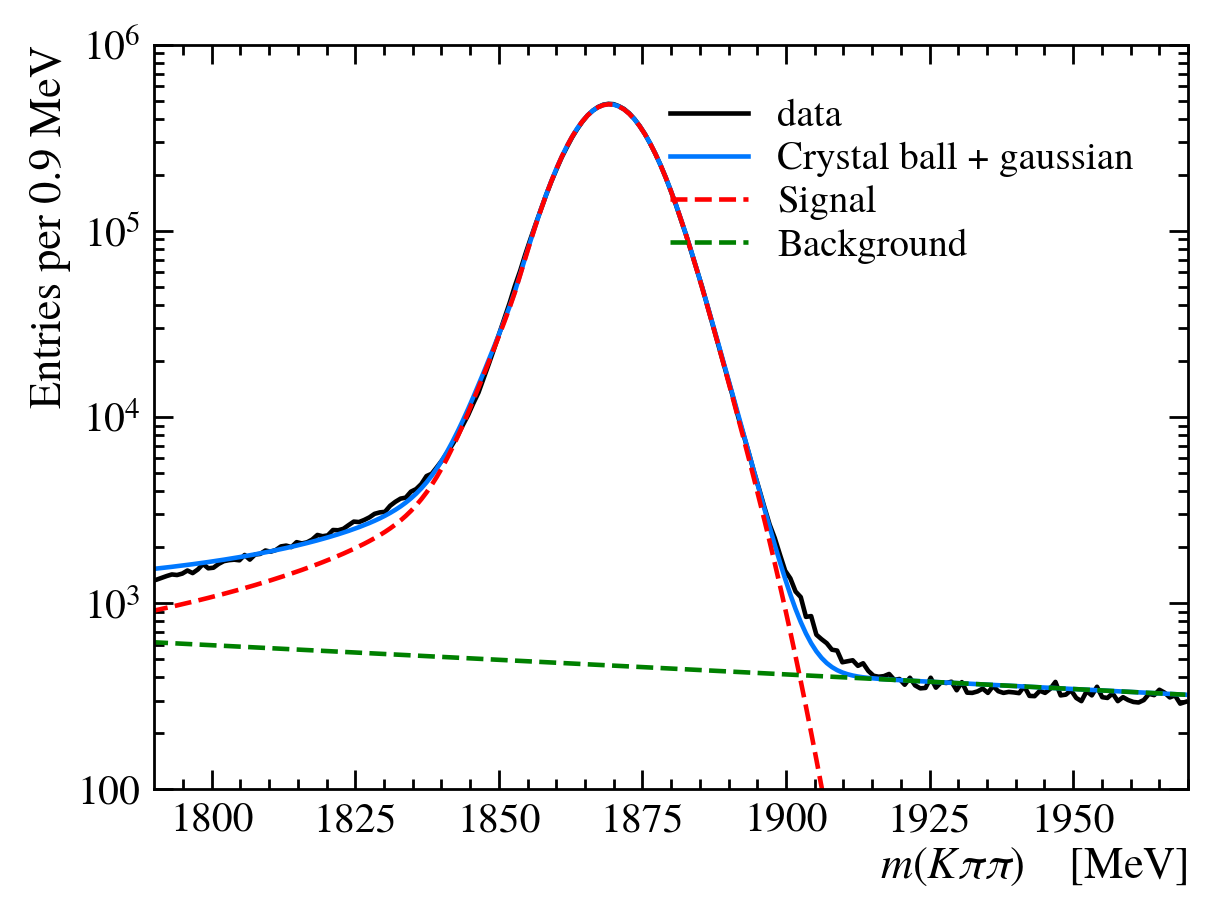

In [65]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,fit_crys1.predict(x), label='Crystal ball + gaussian')
plt.plot(x,crys1_signal(x) * fit_crys1.bin_widths, linestyle='--',color='red', label='Signal')
plt.plot(x, crys1_tail(x) * fit_crys1.bin_widths, linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [ ]:
crys2_mass = Param('mass')(1870)
alpha = Param(5)(0, 10)
n = Param('n')(30)(0, 500)
s1 = (+Param('s1'))(5)
s2 = (+Param('s2'))(6)
s3 = (+Param('s2'))(10)  # Note: original had 's2' but this seems like a typo, keeping for compatibility

crys2_signal = model_sum([
    crystalball(alpha, n, crys2_mass, s1),
    gaussian(crys2_mass, s2), 
    gaussian(crys2_mass, s3)
], 1e6)
crys2_tail = (+Param('Nb'))(40000) * exponential(tau=(+Param)(100), start=1790, end=1970)
crys2 = crys2_signal + crys2_tail

### Crystal Ball + Double Gaussian (crys2)

Extend to Crystal Ball plus double Gaussian for improved resolution modeling.

In [ ]:
fit_crys2 = fit(crys2 | Cost.chi2(Dp_M, 200), numba=False, grad=False)
fit_crys2.minimizer

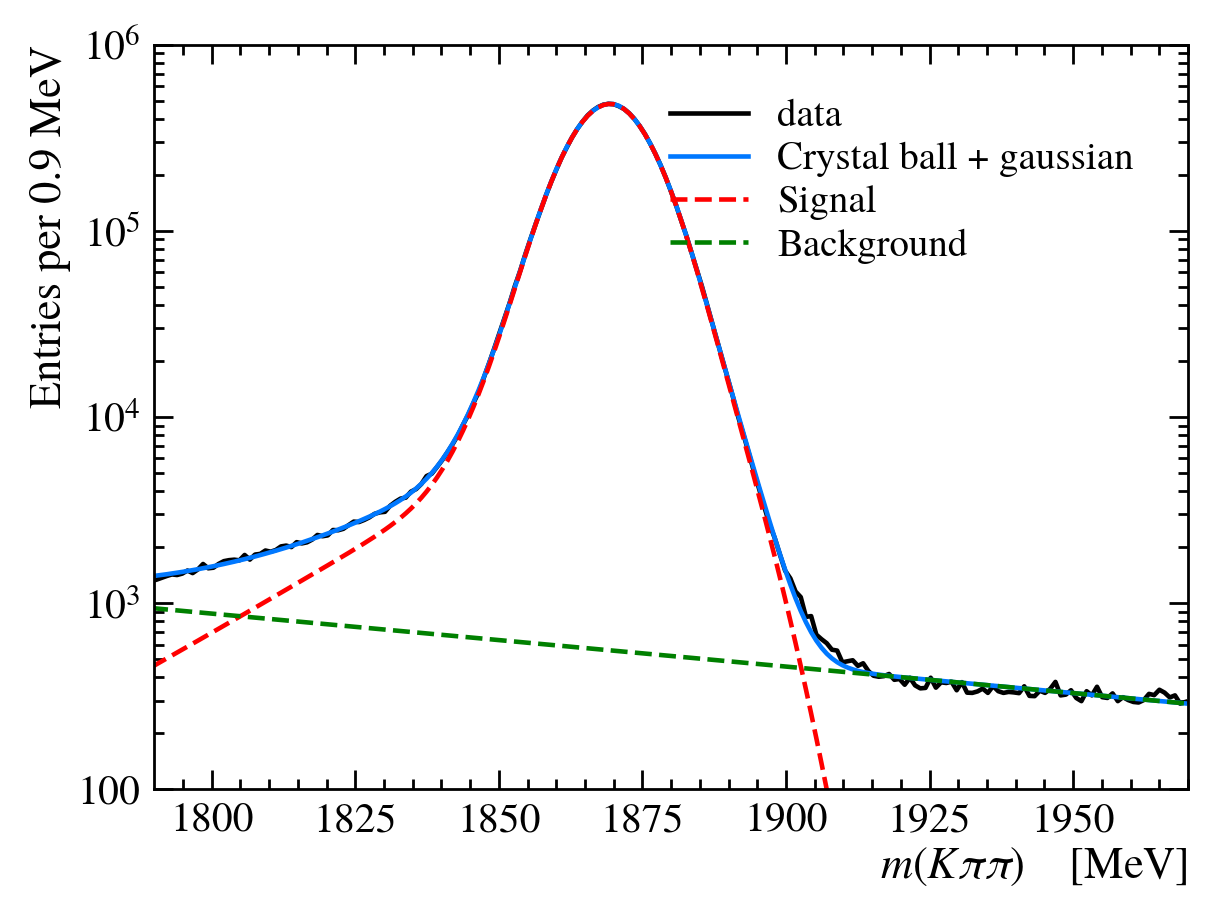

In [53]:
plt.plot(x, counts, color='black', label='data')
plt.plot(x,fit_crys2.predict(x), label='Crystal ball + gaussian')
plt.plot(x,crys2_signal(x) * fit_crys2.bin_widths, linestyle='--',color='red', label='Signal')
plt.plot(x, crys2_tail(x) * fit_crys2.bin_widths, linestyle='--',color='green', label='Background')
plt.yscale('log')
plt.axis([1790,1970, 100,10**6])
plt.xlabel('$m(K \pi \pi)$    [MeV]')
plt.ylabel('Entries per 0.9 MeV')
plt.legend()
plt.show()

In [69]:
fits = [fit_crys1, fit_crys2, fit_conv_kkp, fit_conv1, fit_conv2]
for fit in fits:
    print(f" & {len(fit.values)} & {fit.values['mass']:.3f} ± {fit.errors['mass']:.3f} &  & {fit.fval/(200 - len(fit.values)):.1f} \\\\")

 & 9 & 1869.230 ± 0.003 &  & 13.3 \\
 & 11 & 1869.364 ± 0.005 &  & 2.2 \\
 & 7 & 1869.294 ± 0.003 &  & 39.2 \\
 & 7 & 1869.394 ± 0.003 &  & 5.9 \\
 & 9 & 1869.394 ± 0.003 &  & 2.0 \\


## Results Summary

Compare all fit models for the $D^+ \to K\pi\pi$ channel.

In [34]:
print(len(Dp_M))

10125993


In [71]:
fit_names = {
    fit_crys1: "CB + Gaussian",
    fit_crys2: "CB + DG",
    fit_conv_kkp: "DG KKP Convolution",
    fit_conv1: "DG KPP Convolution",
    fit_conv2: "TG KPP Convolution"
}
for fit in fits:
    print(f"{fit_names[fit]} | {fit.values['N']:.5g} ± {fit.errors['N']:.3g} | {fit.values['Nb']:.3g} ± {fit.errors['Nb']:.3g}  | {(len(Dp_M) - fit.values['N']- fit.values['Nb']):.3g}")

CB + Gaussian | 1.266e+07 ± 8.4e+05 | 1.89e+05 ± 4.18e+03  | -2.72e+06
CB + DG | 1.0027e+07 ± 5.37e+03 | 1.58e+05 ± 1.04e+03  | -5.98e+04
DG KKP Convolution | 9.9913e+06 ± 3.2e+03 | 1.63e+05 ± 850  | -2.83e+04
DG KPP Convolution | 1.0047e+07 ± 3.21e+03 | 2.96e+05 ± 1.53e+04  | -2.17e+05
TG KPP Convolution | 1.0055e+07 ± 3.26e+03 | 3.8e+05 ± 3.84e+04  | -3.09e+05
